In [1]:
%matplotlib notebook

## Philadelphia Housing Analysis - ETL Notebook

## 1.) Dependencies and setup

In [58]:
# 1a.) Define imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import folium
import json

# 1b.) Define source data location and source file 
source_file = 'source_data/housing_data_cleaned.csv'

## 2.) Read in source dataset

In [4]:
# 2a.) Read in source dataset using pd.read_csv
housing_df = pd.read_csv(source_file,low_memory=False)
# 2b.) Verify df load by outputting head
housing_df.head()

,basements,building_code_description,category_code_description,census_tract,central_air,depth,exempt_building,exempt_land,exterior_condition,fireplaces,...,topography,total_area,total_livable_area,type_heater,unit,view_type,year_built,year_built_estimate,zip_code,zoning
0,D,ROW 3 STY MASONRY,Single Family,241.0,N,67.0,49200,0,4.0,0.0,...,F,938.00,1344.0,A,NaN,I,1895,Y,19144,RSA5
1,NaN,ROW 2 STY MASONRY,Single Family,201.0,NaN,70.0,0,0,4.0,0.0,...,F,1044.00,1190.0,NaN,NaN,I,1940,Y,19140,RM1
2,H,ROW B/GAR 2 STY MASONRY,Single Family,281.0,N,95.5,0,0,4.0,0.0,...,F,1686.53,1633.0,B,NaN,I,1940,Y,19141,RSA3
3,NaN,ROW 2 STY MASONRY,Single Family,293.0,NaN,112.5,0,0,4.0,0.0,...,F,2165.62,1320.0,B,NaN,I,1940,Y,19124,RSA5
4,NaN,ROW 2 STY MASONRY,Single Family,62.0,NaN,79.0,0,0,4.0,0.0,...,F,1264.00,960.0,NaN,NaN,I,1920,NaN,19142,RM1


## 3.) Summary Statistics

In [6]:
# 3a.) Prep dataframe read in in step 2 for outputting a summary statistics table
# Create column for year of sale
# NOTE: approach taken from https://stackoverflow.com/questions/25146121/extracting-just-month-and-year-separately-from-pandas-datetime-column
housing_df['sale_year'] = pd.DatetimeIndex(housing_df['sale_date']).year
housing_df['sale_year'].value_counts()

2018    16283
2019    15787
2017    15619
2016    14060
2020     6736
Name: sale_year, dtype: int64

In [7]:
# 3b.) Create group by object and summary dataframe
# Create condensed df with just sale price and year to create summary statistics table
summary_df = housing_df[['sale_price','sale_year']]
summary_df = summary_df.rename(columns={'sale_year':'Year'})

# Create groupby object, group by sale year
summary_df_groupby_obj = summary_df.groupby('Year')

# Create summarys stats table
summary_table_df = summary_df_groupby_obj.agg(['count','mean','median','std'])

# Rename columns

summary_table_df.columns = ['Total Number of Sales','Mean Sale Price','Median Sale Price','Standard Deviation of Sale Price']

In [8]:
# 3c.) Reformat data and output
summary_table_df['Total Number of Sales'] = summary_table_df['Total Number of Sales'].map('{:,.0f}'.format)
summary_table_df['Mean Sale Price'] = summary_table_df['Mean Sale Price'].map('${:,.0f}'.format)
summary_table_df['Median Sale Price'] = summary_table_df['Median Sale Price'].map('${:,.0f}'.format)
summary_table_df['Standard Deviation of Sale Price'] = summary_table_df['Standard Deviation of Sale Price'].map('${:,.0f}'.format)

summary_table_df

,Total Number of Sales,Mean Sale Price,Median Sale Price,Standard Deviation of Sale Price
Year,,,,
2016,"14,060","$177,132","$125,000","$240,260"
2017,"15,619","$219,403","$140,000","$408,161"
2018,"16,283","$206,449","$155,000","$272,475"
2019,"15,787","$221,614","$153,000","$433,686"
2020,"6,736","$257,225","$170,000","$429,846"


## 4.) Boxplot Analysis

 4a.) Boxplot and quartile analysis for population dataset

<IPython.core.display.Javascript object>


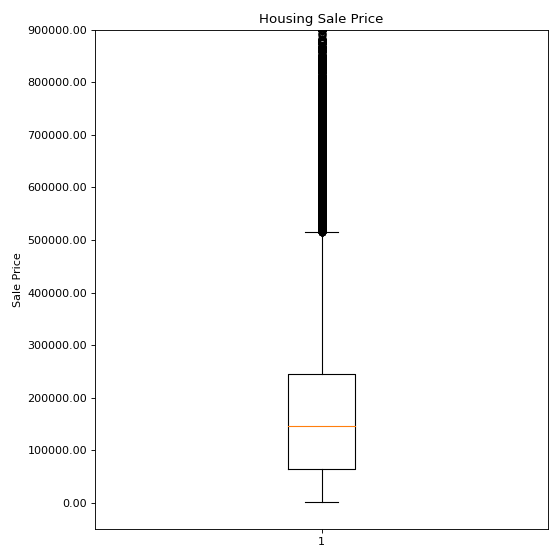

In [19]:
# Create boxplot
sales = housing_df['sale_price']

fig1, ax1 = plt.subplots(figsize=(7, 7))
ax1.set_title('Housing Sale Price')
ax1.set_ylabel('Sale Price')
ax1.boxplot(sales)

top = 900000
bottom = -50000
ax1.set_ylim(bottom, top)

ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%2.2f'))

loc = ticker.MultipleLocator(base=100000.0) 
ax1.yaxis.set_major_locator(loc)


plt.show()
plt.tight_layout()

In [20]:
# Quartile analysis
quartiles = sales.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of sale price is: {lowerq}")
print(f"The upper quartile of sale price is: {upperq}")
print(f"The interquartile range of sale price is: {iqr}")
print(f"The the median of sale price is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile of sale price is: 65000.0
The upper quartile of sale price is: 245000.0
The interquartile range of sale price is: 180000.0
The the median of sale price is: 147000.0 
Values below -205000.0 could be outliers.
Values above 515000.0 could be outliers.


4b.) Boxplot separated by category description

<IPython.core.display.Javascript object>


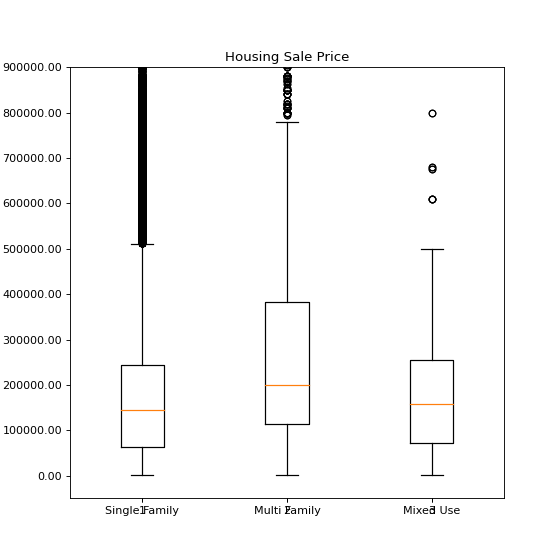

In [22]:
# Create boxplot separated by category code description
code_list = ["Single Family", "Multi Family", "Mixed Use"]

category_code_list= housing_df.groupby('category_code_description')['sale_price'].apply(list)
category_code_list_df = pd.DataFrame(category_code_list)
category_code_list_df = category_code_list_df.reindex(code_list)
sale_price = [price for price in category_code_list_df['sale_price']]



fig1, ax1 = plt.subplots(figsize=(7, 7))
ax1.set_title('Housing Sale Price')
ax1.set_ylabel('Sale Price')
ax1.boxplot(sale_price)

top = 900000
bottom = -50000
ax1.set_ylim(bottom, top)

ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%2.2f'))

loc = ticker.MultipleLocator(base=100000.0) 
ax1.yaxis.set_major_locator(loc)

plt.boxplot(sale_price, labels=code_list)

plt.show()

In [25]:
# Quartile analysis for single family
single_family_df = housing_df.loc[housing_df["category_code_description"] == "Single Family",:]['sale_price']
multi_family_df = housing_df.loc[housing_df["category_code_description"] == "Multi Family",:]['sale_price']
mixed_use_df = housing_df.loc[housing_df["category_code_description"] == "Mixed Use",:]['sale_price']


quartiles = single_family_df.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile sale price for single family housing is: {lowerq}")
print(f"The upper quartile sale price for single family housing is: {upperq}")
print(f"The interquartile range for single family housing is: {iqr}")
print(f"The median of sale price for single family housing is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile sale price for single family housing is: 64000.0
The upper quartile sale price for single family housing is: 243000.0
The interquartile range for single family housing is: 179000.0
The median of sale price for single family housing is: 145000.0 
Values below -204500.0 could be outliers.
Values above 511500.0 could be outliers.


In [27]:
# Quartile analysis for multi family
quartiles = multi_family_df.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile sale price for multi family housing is: {lowerq}")
print(f"The upper quartile sale price for multi family housing is: {upperq}")
print(f"The interquartile range for multi family housing is: {iqr}")
print(f"The median of sale price for multi family housing is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile sale price for multi family housing is: 114932.0
The upper quartile sale price for multi family housing is: 383225.0
The interquartile range for multi family housing is: 268293.0
The median of sale price for multi family housing is: 200000.0 
Values below -287507.5 could be outliers.
Values above 785664.5 could be outliers.


In [28]:
# Quartile analysis for mixed use
quartiles = mixed_use_df.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile sale price for mixed use housing is: {lowerq}")
print(f"The upper quartile sale price for mixed use housing is: {upperq}")
print(f"The interquartile range for mixed use housing is: {iqr}")
print(f"The median of sale price for mixed use housing is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile sale price for mixed use housing is: 72500.0
The upper quartile sale price for mixed use housing is: 255000.0
The interquartile range for mixed use housing is: 182500.0
The median of sale price for mixed use housing is: 157000.0 
Values below -201250.0 could be outliers.
Values above 528750.0 could be outliers.


4c.) Boxplot separated by year

<IPython.core.display.Javascript object>


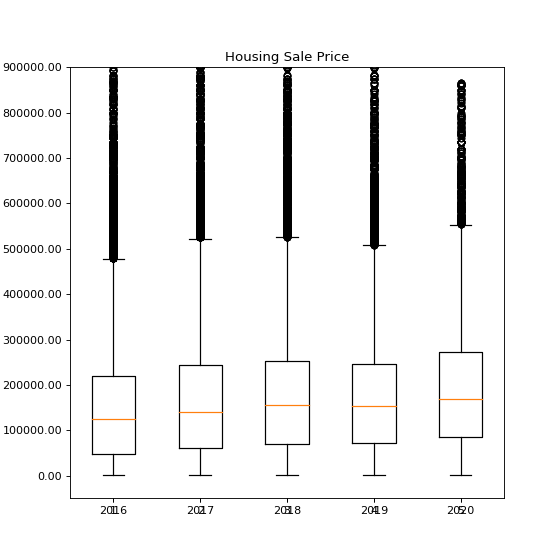

In [40]:
# Create boxplot separated by year
year_list = ['2016','2017','2018','2019','2020']

sale_year_list= housing_df.groupby('sale_year')['sale_price'].apply(list)
sale_year_list_df = pd.DataFrame(sale_year_list)
# sale_year_list_df = sale_year_list_df.reindex(year_list)
sale_price = [price for price in sale_year_list_df['sale_price']]

# sale_year_list_df

fig1, ax1 = plt.subplots(figsize=(7, 7))
ax1.set_title('Housing Sale Price')
ax1.set_ylabel('Sale Price')
ax1.boxplot(sale_price)

top = 900000
bottom = -50000
ax1.set_ylim(bottom, top)

ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%2.2f'))

loc = ticker.MultipleLocator(base=100000.0) 
ax1.yaxis.set_major_locator(loc)

plt.boxplot(sale_price, labels=year_list)

plt.show()

In [42]:
# **** INSERT QUARTILE ANALYSIS FOR SALE PRICE BY YEAR *****

## 5.) 5 Year Trend Analysis

In [51]:
housing_df_year = housing_df
housing_df_year['sale_date'] = pd.DatetimeIndex(housing_df['sale_date']).year

sale_market = housing_df_year.groupby('sale_date')[['sale_price','market_value']].agg(['mean','median','max','min'])

sale_market = sale_market.rename(columns = {'sale_price':'Average Sale Price',
                                            'market_value':'Average Market Value',
                                            'mean':'Mean Price',
                                            'median':'Median Price',
                                            'max':'Largest Sale',
                                            'min':'Smallest Sale'})

sale_market = sale_market.style.format('${:,.2f}')
sale_market

In [52]:
#### Obtained from Freddie Mac website 
#### http://www.freddiemac.com/pmms/pmms30.html

interest_rates = pd.DataFrame({'sale_date':[2020,2019,2018,2017,2016],
'Annual Average':[3.11,3.94,4.54,3.99,3.65]})

interest_rates

,sale_date,Annual Average
0,2020,3.11
1,2019,3.94
2,2018,4.54
3,2017,3.99
4,2016,3.65


<IPython.core.display.Javascript object>


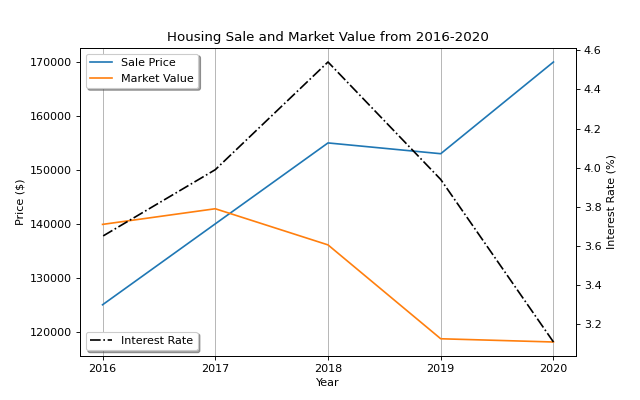

In [53]:
# Sale Price and Market Value 5 year Trends
sale_data = housing_df_year.groupby('sale_date')[['sale_price','market_value']].agg(['median'])
xticks = housing_df_year['sale_date'].unique()
ir_data = interest_rates['Annual Average']

### Single Plot
fig,ax1 = plt.subplots(figsize=(8,5))
ax2=ax1.twinx()

ax1.plot(sale_data, label=['Sale Price','Market Value'],ls='-')
ax1.set_xlabel('Year'), ax1.set_ylabel('Price ($)')
ax1.set_title('Housing Sale and Market Value from 2016-2020')
ax1.legend(loc='upper left',shadow=True)
ax1.grid(axis='x')

ax2.plot(xticks,ir_data,'k',label='Interest Rate',ls='-.')
ax2.set_xlabel('Year'), ax2.set_ylabel('Interest Rate (%)')
ax2.legend(loc='lower left',shadow=True)

plt.xticks(xticks)
plt.show()

## 6.) Zip Code Analysis

### Count of sales by zip
* This explores the total number of home sales by zip code
* Across all dates in the file
* This will show overtime, where most homes are sold

In [54]:
# Aggregate total sales by zip code

# Create df to use for grouping
salesCount = housing_df[['zip_code','sale_price']]

salesCount = salesCount.dropna(how='any')

# Convert to string in main ETL
salesCount['zip_code'] = salesCount['zip_code'].astype('Int64').astype('str')


# Create groupby object
salesCount_groupby = salesCount.groupby('zip_code')

# Create grouped data frame with count of sales, mean, median sale price
salesCount_groupbyDF = salesCount_groupby.count()
salesCount_groupbyDF = salesCount_groupbyDF.reset_index()
salesCount_groupbyDF

# Add zip codes 19109 and 19102, so that GeoJSON will work - not in original df but in GeoJSON file
salesCount_groupbyDF = salesCount_groupbyDF.append({'zip_code':'19109','sale_price':0},ignore_index=True)
salesCount_groupbyDF = salesCount_groupbyDF.append({'zip_code':'19112','sale_price':0},ignore_index=True)

#salesCount_groupbyDF['zip_code'].value_counts()

salesCount_groupbyDF.head()

,zip_code,sale_price
0,19102,16
1,19103,223
2,19104,640
3,19106,47
4,19107,67


In [68]:
with open('source_data/Zipcodes_Poly.geojson','r') as jsonFile:
    data = json.load(jsonFile)
    
# Create folium map
m = folium.Map(location=[39.9526, -75.1652],zoom_start=11)
m.choropleth(
    geo_data=data,
    fill_opacity=0.7,
    line_opacity=0.2,
    data=salesCount_groupbyDF,
    key_on='feature.properties.CODE',
    columns=['zip_code','sale_price'],
    fill_color='YlGnBu',
    legend_name='Number of Sales by Zip Code'
)
folium.LayerControl().add_to(m)

# choropleth.geojson.add_child(
#     folium.features.GeoJsonTooltip(['zip_code'], labels=True))

m

### Average of sales by zip
* This explores the average sale price by zip code
* Across all dates in the file
* This will show overtime the average price of a residence sold

In [63]:
# Aggregate total sales by zip code

# Create df to use for grouping
salesAvg = housing_df[['zip_code','sale_price']]

salesAvg = salesAvg.dropna(how='any')

# Convert to string in main ETL
salesAvg['zip_code'] = salesAvg['zip_code'].astype('Int64').astype('str')


# Create groupby object
salesAvg_groupby = salesAvg.groupby('zip_code')

# Create grouped data frame with count of sales, mean, median sale price
salesAvg_groupbyDF = salesAvg_groupby.mean()
salesAvg_groupbyDF = salesAvg_groupbyDF.reset_index()
salesAvg_groupbyDF

# Add zip codes 19109 and 19102, so that GeoJSON will work - not in original df but in GeoJSON file
salesAvg_groupbyDF = salesAvg_groupbyDF.append({'zip_code':'19109','sale_price':0},ignore_index=True)
salesAvg_groupbyDF = salesAvg_groupbyDF.append({'zip_code':'19112','sale_price':0},ignore_index=True)

salesAvg_groupbyDF.head()

,zip_code,sale_price
0,19102,9.102812e+05
1,19103,1.340693e+06
2,19104,2.709431e+05
3,19106,1.040698e+06
4,19107,9.797343e+05


In [65]:
# Load in GeoJSON file for map
with open('source_data/Zipcodes_Poly.geojson','r') as jsonFile:
    data = json.load(jsonFile)
    
# Create folium map
m = folium.Map(location=[39.9526, -75.1652],zoom_start=11)
m.choropleth(
    geo_data=data,
    fill_opacity=0.7,
    line_opacity=0.2,
    data=salesAvg_groupbyDF,
    key_on='feature.properties.CODE',
    columns=['zip_code','sale_price'],
    fill_color='YlGnBu',
    legend_name='Average Home Sale Prices by Zip Code'
)

folium.LayerControl().add_to(m)

m